# BERTopic Topic Modeling on Mental Health Counseling Conversations (Lemmatized)

## Purpose
The purpose of this notebook is to apply **BERTopic** on mental-health counseling conversations using a preprocessing configuration with **lemmatization and stopword removal**.

At the end of this notebook, you will be able to:
- Generate semantic embeddings using transformer models.
- Perform dimensionality reduction with **UMAP**.
- Cluster documents using **HDBSCAN** to form initial topics.
- Extract dominant keywords from topics using **c-TF-IDF**.
- Evaluate topic quality quantitatively (semantic coherence, , outlier ratio) and qualitatively (manual validation).
- Visualize topic distributions and interpret semantic structures.

## Dataset Overview
- Source: Cleaned & deduplicated counseling conversations (994 entries).  
- Focus: `questionText` column only.  
- Preprocessing: Lemmatization active + stopword removal.

## BERTopic Overview
**BERTopic** is a transformer-based topic modeling technique that leverages:
- Contextual embeddings (e.g., `all-mpnet-base-v2`)  
- Dimensionality reduction (**UMAP**)  
- Density-based clustering (**HDBSCAN**)  
- Class-based TF-IDF (**c-TF-IDF**) for topic representation  

This approach captures semantically rich themes from unstructured and emotionally nuanced text.

## Evaluation Approach
- **Quantitative metrics**:  
  - Semantic coherence (c_V, NPMI)  
  - Topic diversity  
  - Outlier ratio  
- **Qualitative analysis**:  
  - Manual inspection of representative documents per topic  
  - Validation across variation in topic size, psychological domain, and coherence score

## Visualization
- **UMAP projections** for observing topic clusters  
- **Keyword distributions** from c-TF-IDF for evaluating internal semantic structure


## Install Required Packages
Run the following cell to install all necessary Python libraries for BERTopic modeling and visualization.

In [ ]:
pip install bertopic[visualization] sentence-transformers umap-learn hdbscan contractions symspellpy gensim

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

## Mount Google Drive (Optional)

If your dataset is stored in Google Drive, run the following cell to mount your Drive and access the files.  
If your data is local, you can skip this step.

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

## Load and Combine Dataset

- Read the two CSV files containing counseling conversation texts (`questionText`).  
- Drop any missing values and remove duplicate entries.  
- Combine the two datasets into a single DataFrame with unique questions only.  
- Save the combined dataset for further preprocessing and BERTopic modeling.

In [ ]:
import pandas as pd

# Load datasets from local folder
df1 = pd.read_csv("counselchat-data.csv", usecols=["questionText"], on_bad_lines='skip')
df2 = pd.read_csv("20200325_counsel_chat.csv", usecols=["questionText"], on_bad_lines='skip')

# Drop missing values
q1 = df1["questionText"].dropna()
q2 = df2["questionText"].dropna()

# Combine datasets, remove duplicates, reset index
combined_q = pd.concat([q1, q2], ignore_index=True).drop_duplicates().reset_index(drop=True)

print("Number of unique questions:", len(combined_q))

# Save combined dataset locally
combined_q.to_frame(name="questionText").to_csv("combined_questionText.csv", index=False)

## Validate and Combine Data

- Display the number of valid (non-missing) questions in each dataset.  
- Merge both datasets into a single DataFrame.  
- Remove duplicate questions and reset the index.  
- Display the total number of unique questions after merging.


In [ ]:
# Check dataset after dropping missing values
print("After dropping NA values:")
print("counselchat-data.csv (valid entries):", len(q1))
print("20200325_counsel_chat.csv (valid entries):", len(q2))

# Combine datasets, remove duplicates, reset index
combined_questions = pd.concat([q1, q2], ignore_index=True).drop_duplicates().reset_index(drop=True)
print("Number of unique questions after merging:", len(combined_questions))

## Preview Combined Dataset

Display the first few rows of the combined and deduplicated dataset to inspect the structure and content of the questions.


In [ ]:
print(combined_q.head())

## Text Preprocessing

This section performs comprehensive preprocessing on the counseling conversation dataset to prepare it for topic modeling using **BERTopic**. Effective preprocessing is critical because counseling texts are often unstructured, contain typos, informal shorthand, and emotionally rich content. Clean and consistent text ensures that embeddings generated from **SentenceTransformers** accurately capture semantic meaning, improving topic coherence and interpretability.

### Steps:

1. **Normalization**  
   Converts characters to ASCII format to remove accents or special Unicode characters.  
   *Example:* `"café"` → `"cafe"`  

2. **Contraction Expansion**  
   Expands common English contractions.  
   *Example:* `"don't"` → `"do not"`, `"I'm"` → `"I am"`  

3. **Lowercasing**  
   Converts all text to lowercase.  
   *Example:* `"Stress"` → `"stress"`  

4. **Typo Correction**  
   Corrects typos using:
   - **SymSpell:** detects and corrects spelling errors based on edit distance.  
   - **Custom Manual Dictionary:** handles domain-specific or frequent shorthand that SymSpell might miss.  
   *Example:* `"btw"` → `"by the way"`, `"u"` → `"you"`  

5. **Non-alphabetic Character Removal**  
   Removes numbers, punctuation, emojis, and special symbols.  
   *Example:* `"I feel sad 😢 today"` → `"i feel sad today"`  

6. **Whitespace Cleanup**  
   Standardizes spaces and strips leading/trailing whitespace.  

7. **Optional Lemmatization**  
   Reduces words to their base form using **spaCy**.  
   *Example:* `"running"` → `"run"`, `"anxious"` → `"anxious"`  

8. **Optional Stopword Removal**  
   Removes common English stopwords to focus on meaningful words.  
   *Example:* `"I feel very stressed today"` → `"feel stressed today"`  

9. **Handling Short or Empty Texts** *(optional but recommended)*  
   Filters out extremely short or empty questions to prevent skewed clustering.  

### Output:
The cleaned text is stored as a **list of strings**, ready for embedding generation and topic modeling with BERTopic.

### Notes / Recommendations:
- Maintaining a **manual dictionary** is important for counseling text due to shorthand, slang, or therapist-specific terms.  
- Preprocessing steps can be **toggled on/off** to compare impact on topic coherence and interpretability.  
- Optional **visual checks** (like word clouds or sample text before/after cleaning) help validate that preprocessing preserves the meaning of conversations.


In [ ]:
import pandas as pd
import contractions
import re
import spacy
import unicodedata
import pkg_resources
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from symspellpy import SymSpell, Verbosity

# Load English NLP model
nlp = spacy.load("en_core_web_sm")

# Initialize SymSpell for typo correction
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Manual typo correction dictionary (domain-specific)
manual_dict = {
    "st": "at"
}

# Function to correct typos using manual dictionary and SymSpell
def correct_typos(text):
    words = text.split()
    corrected = []
    for word in words:
        if word in manual_dict:
            corrected.append(manual_dict[word])
        else:
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
            if suggestions:
                corrected.append(suggestions[0].term)
            else:
                corrected.append(word)
    return " ".join(corrected)

# Main preprocessing function
def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    # Normalize unicode characters
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")
    
    # Expand contractions (e.g., "don't" → "do not")
    text = contractions.fix(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Correct typos
    text = correct_typos(text)
    
    # Remove non-alphabetic characters
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Clean extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    # Lemmatize (optional)
    if lemmatize:
        doc = nlp(text)
        text = " ".join([token.lemma_ for token in doc])
    
    # Remove stopwords (optional)
    if remove_stopwords:
        words = [word for word in text.split() if word not in ENGLISH_STOP_WORDS]
        text = " ".join(words)
    
    return text

# Apply preprocessing to the combined dataset
cleaned_texts = combined_q.astype(str).apply(preprocess_text).tolist()


## Generating Text Embeddings

After preprocessing, the counseling conversation texts are converted into **numerical vector embeddings**.  
These embeddings allow the model to understand the **semantic meaning** of each text rather than just the individual words.

### Why Embeddings Are Needed
- Similar topics (e.g., family disagreements) will be positioned close together in high-dimensional space.
- Embeddings enable **clustering algorithms** (HDBSCAN, UMAP) to detect meaningful patterns.
- Facilitates **topic modeling** using BERTopic on unstructured, nuanced psychological data.

### Method
1. **Model:** `all-mpnet-base-v2` from SentenceTransformers.  
2. **Batch Processing:** 32 texts per batch to optimize memory usage.  
3. **Normalization:** Embeddings are normalized for stable clustering.  
4. **Output:** A matrix of shape `(number of documents, embedding dimension)` ready for clustering.


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Example of raw counseling conversation snippets (for context)
# These are unstructured texts with nuanced psychological topics:
# - "wife mother tense disagreement past ve minor"
# - "difference example wife complain I mother overbearing mother complain wife"
# - "lazy intensify lately I think cause wife talk little disagreement"
# - "magnify lead major"
# These texts will be converted into vector embeddings for topic modeling.

def create_embeddings(texts):
    """
    Generate vector embeddings for a list of texts using SentenceTransformer.

    Args:
        texts (list of str): Preprocessed counseling conversation texts.

    Returns:
        np.ndarray: Array of embeddings (documents x embedding dimension).
    """
    # Load pre-trained transformer model
    embedding_model = SentenceTransformer("all-mpnet-base-v2")

    batch_size = 32  # Process 32 texts per batch for efficiency
    embeddings = []  # List to store embeddings

    # Encode texts in batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        emb = embedding_model.encode(
            batch,
            normalize_embeddings=True,  # Normalized embeddings improve clustering stability
            show_progress_bar=False
        )
        embeddings.append(emb)

    # Combine all batches into a single numpy array
    embeddings = np.vstack(embeddings)
    print(f"Embeddings shape: {embeddings.shape}")

    return embeddings

# Generate embeddings for preprocessed texts
embeddings = create_embeddings(texts)


## Topic Modeling with BERTopic

In this step, we use **BERTopic**, a modern transformer-based topic modeling framework, to uncover latent psychological themes in the counseling conversation dataset.

### Method Overview

1. **Dimensionality Reduction with UMAP**
   - Precomputed embeddings are projected into a lower-dimensional space (5 dimensions) for efficient clustering.
   - `n_neighbors=15` defines the local neighborhood size.
   - `min_dist=0.0` preserves the global structure of embeddings.

2. **Clustering with HDBSCAN**
   - Detects dense clusters of semantically similar conversations.
   - `min_cluster_size=10` ensures small, meaningful topics are captured.
   - `prediction_data=True` enables probabilistic assignment of documents to clusters.

3. **BERTopic Model Configuration**
   - Combines UMAP + HDBSCAN + c-TF-IDF to generate semantically coherent topics.
   - `min_topic_size=5` filters out very small clusters to reduce noise.
   - `calculate_probabilities=True` allows soft assignment of documents to topics.

4. **Output**
   - `topic_model`: The trained BERTopic object.
   - `topics`: Topic ID assigned to each document.
   - `probs`: Probability of each document belonging to each topic.

### Notes

- Using precomputed embeddings improves speed and allows more control over the representation space.
- This setup is particularly suitable for **emotionally nuanced and unstructured text** like counseling conversations.
- The resulting topics can later be visualized using UMAP or analyzed for semantic insights.


In [ ]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

def train_bertopic(texts, embeddings):
    """
    Train a BERTopic model on preprocessed texts with precomputed embeddings.

    Args:
        texts (list of str): Preprocessed counseling conversation texts.
        embeddings (np.ndarray): Precomputed vector embeddings of the texts.

    Returns:
        topic_model (BERTopic): Trained BERTopic model.
        topics (list[int]): Assigned topic IDs for each document.
        probs (np.ndarray): Probability distribution over topics for each document.
    """

    # Configure UMAP for dimensionality reduction of embeddings
    umap_model = UMAP(
        n_neighbors=15,
        n_components=5,
        min_dist=0.0,
        metric='cosine',
        random_state=42
    )

    # Configure HDBSCAN for clustering the UMAP-projected embeddings
    hdbscan_model = HDBSCAN(
        min_cluster_size=10,
        metric='euclidean',
        prediction_data=True
    )

    # Initialize BERTopic model
    topic_model = BERTopic(
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=5,
        verbose=True,
        calculate_probabilities=True
    )

    # Fit the BERTopic model and obtain topic assignments and probabilities
    topics, probs = topic_model.fit_transform(texts, embeddings)

    return topic_model, topics, probs

# Train the BERTopic model on preprocessed texts and embeddings
topic_model, topics, probs = train_bertopic(texts, embeddings)


## BERTopic Coherence Evaluation

After training the BERTopic model, we evaluate the quality of the extracted topics using both **quantitative** and **semantic metrics**.

### 1. Top Words Extraction
- For each topic, the top 10 representative words are extracted using **c-TF-IDF**.
- These words summarize the main theme of the topic.

### 2. Coherence Metrics
We calculate three standard coherence metrics using Gensim:

1. **C_V**: Combines cosine similarity and normalized pointwise mutual information (NPMI) over sliding windows.
2. **NPMI**: Measures normalized mutual information between top words in a topic.
3. **U_Mass**: Measures co-occurrence of words in the corpus (Important: sensitive to corpus sparsity).

### 3. Topic Diversity
- Defined as the proportion of unique words in the top-N words across all topics.
- High diversity indicates that topics capture a broad range of concepts without redundancy.

### 4. Data Preprocessing
- Texts were **lemmatized**, **cleaned**, and **stopwords removed**.
- Typo correction was performed using **SymSpell** and a **custom domain-specific dictionary**.
- Preprocessed texts were tokenized for Gensim coherence calculation.

### 5. Summary Table
- Provides an overview of each topic:
  - **Topic_ID**: Unique identifier
  - **Top_Words**: Most representative words
  - **C_V**, **NPMI**, **U_Mass**: Coherence scores
  - **Topic Diversity**: Single overall value

This evaluation ensures that the extracted topics are **both semantically meaningful and diverse**, which is critical for actionable insights from counseling conversations.


In [ ]:
from bertopic import BERTopic
import pandas as pd
import numpy as np
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import contractions, re, spacy, unicodedata, pkg_resources
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from symspellpy import SymSpell, Verbosity

#------------------------
# Load pre-trained BERTopic model and results
#------------------------
topic_model = BERTopic.load("/content/drive/MyDrive/Thesis/L-ON_S-ON/bertopic_model")

# Inject previously saved topics and probabilities
topic_model.topics_ = np.load("/content/drive/MyDrive/Thesis/L-ON_S-ON/topics.npy", allow_pickle=True)
topic_model.probabilities_ = np.load("/content/drive/MyDrive/Thesis/L-ON_S-ON/probs.npy", allow_pickle=True)

# Optional: load embeddings if needed for visualization or re-transform
embeddings = np.load("/content/drive/MyDrive/Thesis/L-ON_S-ON/embeddings.npy", allow_pickle=True)

#------------------------
# Load and combine datasets
#------------------------
df1 = pd.read_csv("/content/drive/My Drive/Thesis/counselchat-data.csv", usecols=["questionText"], on_bad_lines='skip')
df2 = pd.read_csv("/content/drive/My Drive/Thesis/20200325_counsel_chat.csv", usecols=["questionText"], on_bad_lines='skip')

q1 = df1["questionText"].dropna()
q2 = df2["questionText"].dropna()

combined_q = pd.concat([q1, q2], ignore_index=True).drop_duplicates().reset_index(drop=True)

#------------------------
# Text preprocessing
#------------------------
nlp = spacy.load("en_core_web_sm")

# Setup SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Custom typo dictionary
manual_dict = {
    "st": "at",
    "wifes": "wives",
    "mothers": "mother",
    "behviour": "behavior",
    "disgree": "disagree",
    "teh": "the",
    "alot": "a lot",
    # add more common domain-specific typos if needed
}

def correct_typo_custom(text):
    words = text.split()
    corrected = []
    for word in words:
        if word in manual_dict:
            corrected.append(manual_dict[word])
        else:
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
            corrected.append(suggestions[0].term if suggestions else word)
    return " ".join(corrected)

def clean_text(text, remove_stopwords=True, lemmatize=True):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")
    text = contractions.fix(text)
    text = text.lower()
    text = correct_typo_custom(text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    if lemmatize:
        doc = nlp(text)
        text = " ".join([token.lemma_ for token in doc])
    if remove_stopwords:
        text = " ".join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

texts = combined_q.astype(str).apply(clean_text).tolist()
tokenized_texts = [t.split() for t in texts]

#------------------------
# Prepare corpus for Gensim coherence
#------------------------
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

#------------------------
# Extract top words from BERTopic
#------------------------
bertopic_topics = [
    [word for word, _ in topic_model.get_topic(topic_id)[:10]]
    for topic_id in sorted(set(topic_model.topics_)) if topic_id != -1
]

#------------------------
# Calculate coherence metrics
#------------------------
cv = CoherenceModel(topics=bertopic_topics, texts=tokenized_texts, dictionary=dictionary, coherence='c_v').get_coherence_per_topic()
npmi = CoherenceModel(topics=bertopic_topics, texts=tokenized_texts, dictionary=dictionary, coherence='c_npmi').get_coherence_per_topic()
umass = CoherenceModel(topics=bertopic_topics, texts=tokenized_texts, corpus=corpus, dictionary=dictionary, coherence='u_mass').get_coherence_per_topic()

#------------------------
# Topic diversity
#------------------------
def calculate_topic_diversity(topics, top_k=10):
    all_words = [word for topic in topics for word in topic[:top_k]]
    return len(set(all_words)) / len(all_words)

diversity = calculate_topic_diversity(bertopic_topics)

#------------------------
# Summary table
#------------------------
df_summary = pd.DataFrame({
    "Topic_ID": list(range(len(bertopic_topics))),
    "Top_Words": [", ".join(words[:5]) for words in bertopic_topics],
    "C_V": cv,
    "NPMI": npmi,
    "U_Mass": umass
})

print("Average Coherence & Diversity:")
print(f"  C_V: {np.mean(cv):.4f}")
print(f"  NPMI: {np.mean(npmi):.4f}")
print(f"  U_Mass: {np.mean(umass):.4f}")
print(f"  Topic Diversity: {diversity:.4f}")


Average Coherence:
  C_V: 0.4134
  NPMI: -0.1121
  U_Mass: -5.9202
  Diversity: 0.7478


## Top Words per Topic

This section extracts the **top 10 representative words** from each topic generated by the BERTopic model. 

- **Purpose:** These keywords summarize the main semantic theme of each topic, making it easier to interpret the content of counseling conversations.
- **Topics Selected:** Only topics 0 to 22 are included to focus on meaningful clusters.
- **Output:** A neat table where each row represents a topic and columns show the top 10 words in descending importance according to c-TF-IDF scores.

**Important:** Words are sorted by relevance within each topic, providing a quick overview of the psychological themes captured by the model.


In [ ]:
# Define topic IDs to include (0 to 22 if you have 23 topics)
true_topic_ids = list(range(23))  # Topics 0 to 22

# Extract top 10 words per topic from BERTopic
top_words_per_topic = {
    f"Topic {i}": [word for word, _ in topic_model.get_topic(i)[:10]]
    for i in true_topic_ids
}

# Convert dictionary to a DataFrame for neat display
df_keywords = pd.DataFrame.from_dict(
    top_words_per_topic, 
    orient='index', 
    columns=[f"Word_{j+1}" for j in range(10)]
)

# Print full table
print(df_keywords.to_string())


## Display Top Words per Topic

After loading the pre-trained BERTopic model and injecting previously saved topic IDs and probabilities, we can extract the **top keywords** for each topic.  
This helps interpret the topics and understand the key themes discovered from the counseling conversation dataset.


In [ ]:
#Get all valid topic IDs (exclude outliers labeled as -1)
true_topic_ids = sorted(set(topic_model.topics_))
if -1 in true_topic_ids:
    true_topic_ids.remove(-1)

#Extract top 10 words for each topic
top_words_per_topic = {
    f"Topic {tid}": [word for word, _ in topic_model.get_topic(tid)[:10]]
    for tid in true_topic_ids
}

#Convert to a DataFrame for a clean display
df_keywords = pd.DataFrame.from_dict(
    top_words_per_topic,
    orient='index',
    columns=[f"Word_{i+1}" for i in range(10)]
)

#Display the DataFrame
df_keywords


## Topic Summary and Evaluation

This section summarizes the BERTopic model results by creating a **topic evaluation table**.  
It includes:

1. Topic ID  
2. Number of documents per topic  
3. All keywords associated with each topic  

We also check for **outlier documents** labeled as `-1` to assess whether additional preprocessing may be necessary.


In [ ]:
import pandas as pd

# Get topic information from the BERTopic model
df_topic_info = topic_model.get_topic_info()

# Prepare evaluation DataFrame excluding outliers
df_evaluation = df_topic_info[df_topic_info["Topic"] != -1][["Topic", "Count"]].copy()

# Function to get all keywords for a topic
def get_all_keywords(tid):
    return ", ".join([word for word, _ in topic_model.get_topic(tid)])

df_evaluation["Top Words"] = df_evaluation["Topic"].apply(get_all_keywords)

# Add a sequential number column
df_evaluation.insert(0, "No", range(1, len(df_evaluation) + 1))

# Reset index and display all rows
df_evaluation = df_evaluation.reset_index(drop=True)
pd.set_option('display.max_rows', None)
display(df_evaluation)

# Check for outlier documents
if -1 in df_topic_info["Topic"].values:
    num_outliers = df_topic_info[df_topic_info["Topic"] == -1]["Count"].values[0]
    print(f"Number of outlier documents (Topic -1): {num_outliers}")
else:
    print("No documents were categorized as outliers.")


**Notes:**

- `df_topic_info` provides a summary of all topics detected by BERTopic, including the outlier cluster `-1`.  
- `df_evaluation` focuses only on valid topics to give a clear view of the distribution of documents and keywords.  
- Reviewing the number of outliers helps identify if **further preprocessing or data cleaning** is needed.  
- This table is useful for stakeholders to understand the most significant topics and the associated vocabulary in counseling conversations.


## Manual Keyword Inspection per Topic

This section allows us to inspect **specific keywords** within documents belonging to a selected topic.  
We can:

1. Highlight occurrences of chosen keywords.  
2. Count how many times each keyword appears per document.  
3. Summarize total occurrences across the topic.  

By this code, we can **review the vocabulary alphabetically** to detect potential typos or missing words. If any irrelevant or noisy words are found, they can be added to the **stopword list** or corrected in the preprocessing pipeline.


In [ ]:
import re
import pandas as pd
from IPython.display import display, HTML

# Load the cleaned dataset
combined_q = pd.read_csv("combined_questionText.csv")["questionText"]

# Select topic and keywords to track
target_topic = 8  # topic to inspect
custom_keywords = ["transgender"]  # keywords to manually check

# Get indices of documents belonging to the selected topic
topic_indices = [i for i, t in enumerate(topics) if t == target_topic]

# Function to underline keywords & count occurrences
def highlight_and_count_keywords(text, keywords):
    count_dict = {}
    for word in keywords:
        pattern = re.compile(rf"{re.escape(word)}", flags=re.IGNORECASE)
        matches = pattern.findall(text)
        count_dict[word] = len(matches)
        text = pattern.sub(f"<u>{word}</u>", text)
    return text, count_dict

# Display header
display(HTML(f"<h3>📌 Topic {target_topic} — Keywords Checked: [ {', '.join(custom_keywords)} ]</h3>"))
display(HTML(f"<b>Total documents in this topic:</b> {len(topic_indices)}<br><br>"))

# Initialize total counts
total_keyword_counts = {word: 0 for word in custom_keywords}

# Display documents (first 10) and count keywords
for j, i in enumerate(topic_indices[:10], 1):  # change 10 to display more
    text = combined_q.iloc[i]
    underlined, counts = highlight_and_count_keywords(text, custom_keywords)

    # Add to totals
    for k, v in counts.items():
        total_keyword_counts[k] += v

    count_lines = "<br>".join([f"{k}: {v}" for k, v in counts.items() if v > 0])
    display(HTML(f"<b>Document {j} (Index {i}):</b><br>{underlined}<br><br><b>🔍 Keyword Counts:</b><br>{count_lines}<br><br>"))

# Display total occurrences for the topic
total_lines = "<br>".join([f"<b>{k}</b>: {v} times" for k, v in total_keyword_counts.items() if v > 0])
display(HTML(f"<h4>🧾 Total Manual Keyword Occurrences in Topic {target_topic}:</h4><br>{total_lines}"))


## Topic Distribution Visualization

This section visualizes the distribution of documents across **specific psychological themes** (topics) identified by the BERTopic model with active lemmatization.  

- We map topic IDs to **human-readable labels** based on domain interpretation.
- Only valid topic IDs are plotted (excluding outliers `-1`).  
- A horizontal bar chart is used to display the **document count per theme**, helping identify the most prevalent psychological concerns in the counseling dataset.


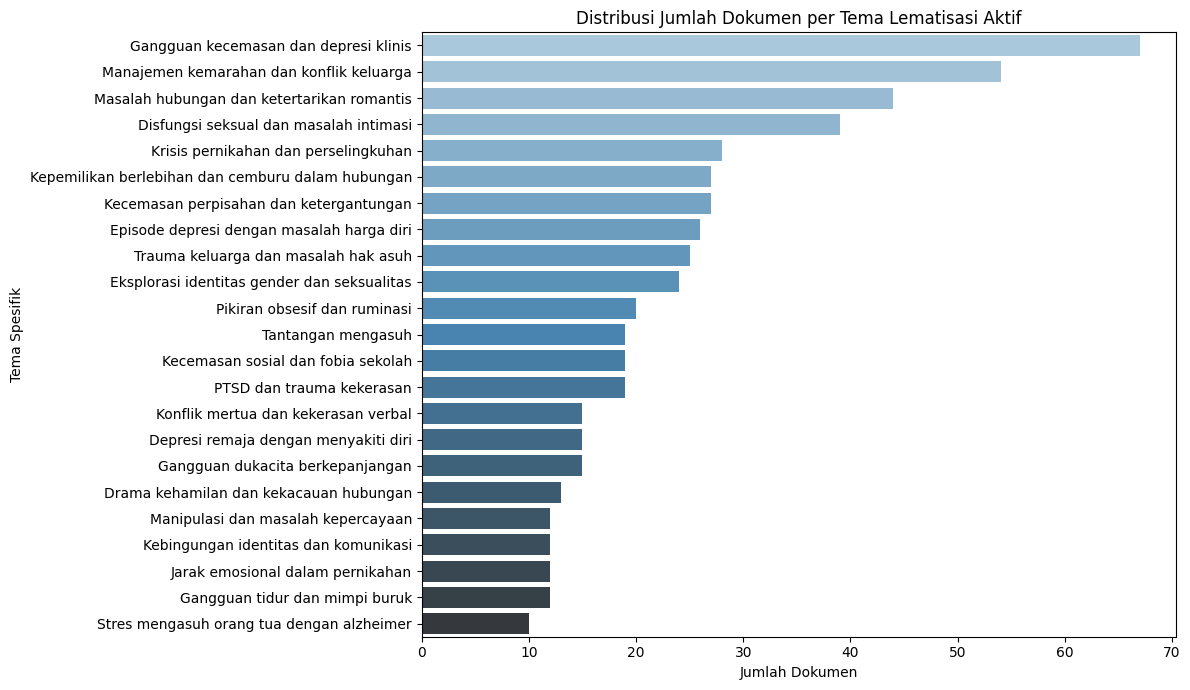

In [ ]:
from bertopic import BERTopic
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the BERTopic model
topic_model = BERTopic.load("/content/drive/MyDrive/Thesis/L-ON_S-ON/bertopic_model")

# Get topic information from the model
df_topic_info = topic_model.get_topic_info()

# Map topic IDs to human-readable labels in Indonesian
# English comment after # aka ...
topic_labels = {
    0: "Gangguan kecemasan dan depresi klinis",        # aka Clinical Anxiety & Depression
    7: "Episode depresi dengan masalah harga diri",   # aka Depression Episodes & Self-Esteem Issues
    10: "Pikiran obsesif dan ruminasi",              # aka Obsessive Thoughts & Rumination
    12: "Kecemasan sosial dan fobia sekolah",       # aka Social Anxiety & School Phobia
    13: "PTSD dan trauma kekerasan",                 # aka PTSD & Trauma
    15: "Depresi remaja dengan menyakiti diri",      # aka Adolescent Depression & Self-Harm
    16: "Gangguan dukacita berkepanjangan",          # aka Prolonged Grief Disorder
    21: "Gangguan tidur dan mimpi buruk",            # aka Sleep Disorders & Nightmares
    2: "Masalah hubungan dan ketertarikan romantis",# aka Relationship & Romantic Issues
    3: "Disfungsi seksual dan masalah intimasi",    # aka Sexual Dysfunction & Intimacy Problems
    4: "Krisis pernikahan dan perselingkuhan",      # aka Marriage Crisis & Infidelity
    5: "Kepemilikan berlebihan dan cemburu",        # aka Over-possessiveness & Jealousy
    6: "Kecemasan perpisahan dan ketergantungan",   # aka Separation Anxiety & Dependency
    17: "Drama kehamilan dan kekacauan hubungan",    # aka Pregnancy Drama & Relationship Chaos
    18: "Manipulasi dan masalah kepercayaan",       # aka Manipulation & Trust Issues
    20: "Jarak emosional dalam pernikahan",         # aka Emotional Distance in Marriage
    1: "Manajemen kemarahan dan konflik keluarga",  # aka Anger Management & Family Conflict
    8: "Trauma keluarga dan masalah hak asuh",      # aka Family Trauma & Custody Issues
    11: "Tantangan mengasuh",                        # aka Parenting Challenges
    14: "Konflik mertua dan kekerasan verbal",      # aka In-Law Conflicts & Verbal Abuse
    22: "Stres mengasuh orang tua dengan alzheimer",# aka Caring for Parents with Alzheimer’s
    9: "Eksplorasi identitas gender dan seksualitas",# aka Gender & Sexuality Exploration
    19: "Kebingungan identitas dan komunikasi",     # aka Identity Confusion & Communication Issues
}

# Filter and map labels
df_plot = df_topic_info[df_topic_info["Topic"].isin(topic_labels.keys())].copy()
df_plot["Tema Spesifik"] = df_plot["Topic"].map(topic_labels)

# Plot Histogram
plt.figure(figsize=(12, 7))
sns.barplot(y="Tema Spesifik", x="Count", data=df_plot, palette="Blues_d")
plt.title("Distribusi Jumlah Dokumen per Tema Lematisasi Aktif")
plt.xlabel("Jumlah Dokumen")
plt.ylabel("Tema Spesifik")
plt.tight_layout()
plt.show()

## Word Cloud Visualization for Each Topic

This section generates **word clouds** for each topic identified by the BERTopic model (with active lemmatization).  

- Only valid topic IDs (those mapped to human-readable labels) are visualized.  
- Word size represents **importance/frequency** of the term in the topic.  
- The word clouds are arranged in a **3-column grid**, with each cloud labeled by topic ID and its corresponding theme.


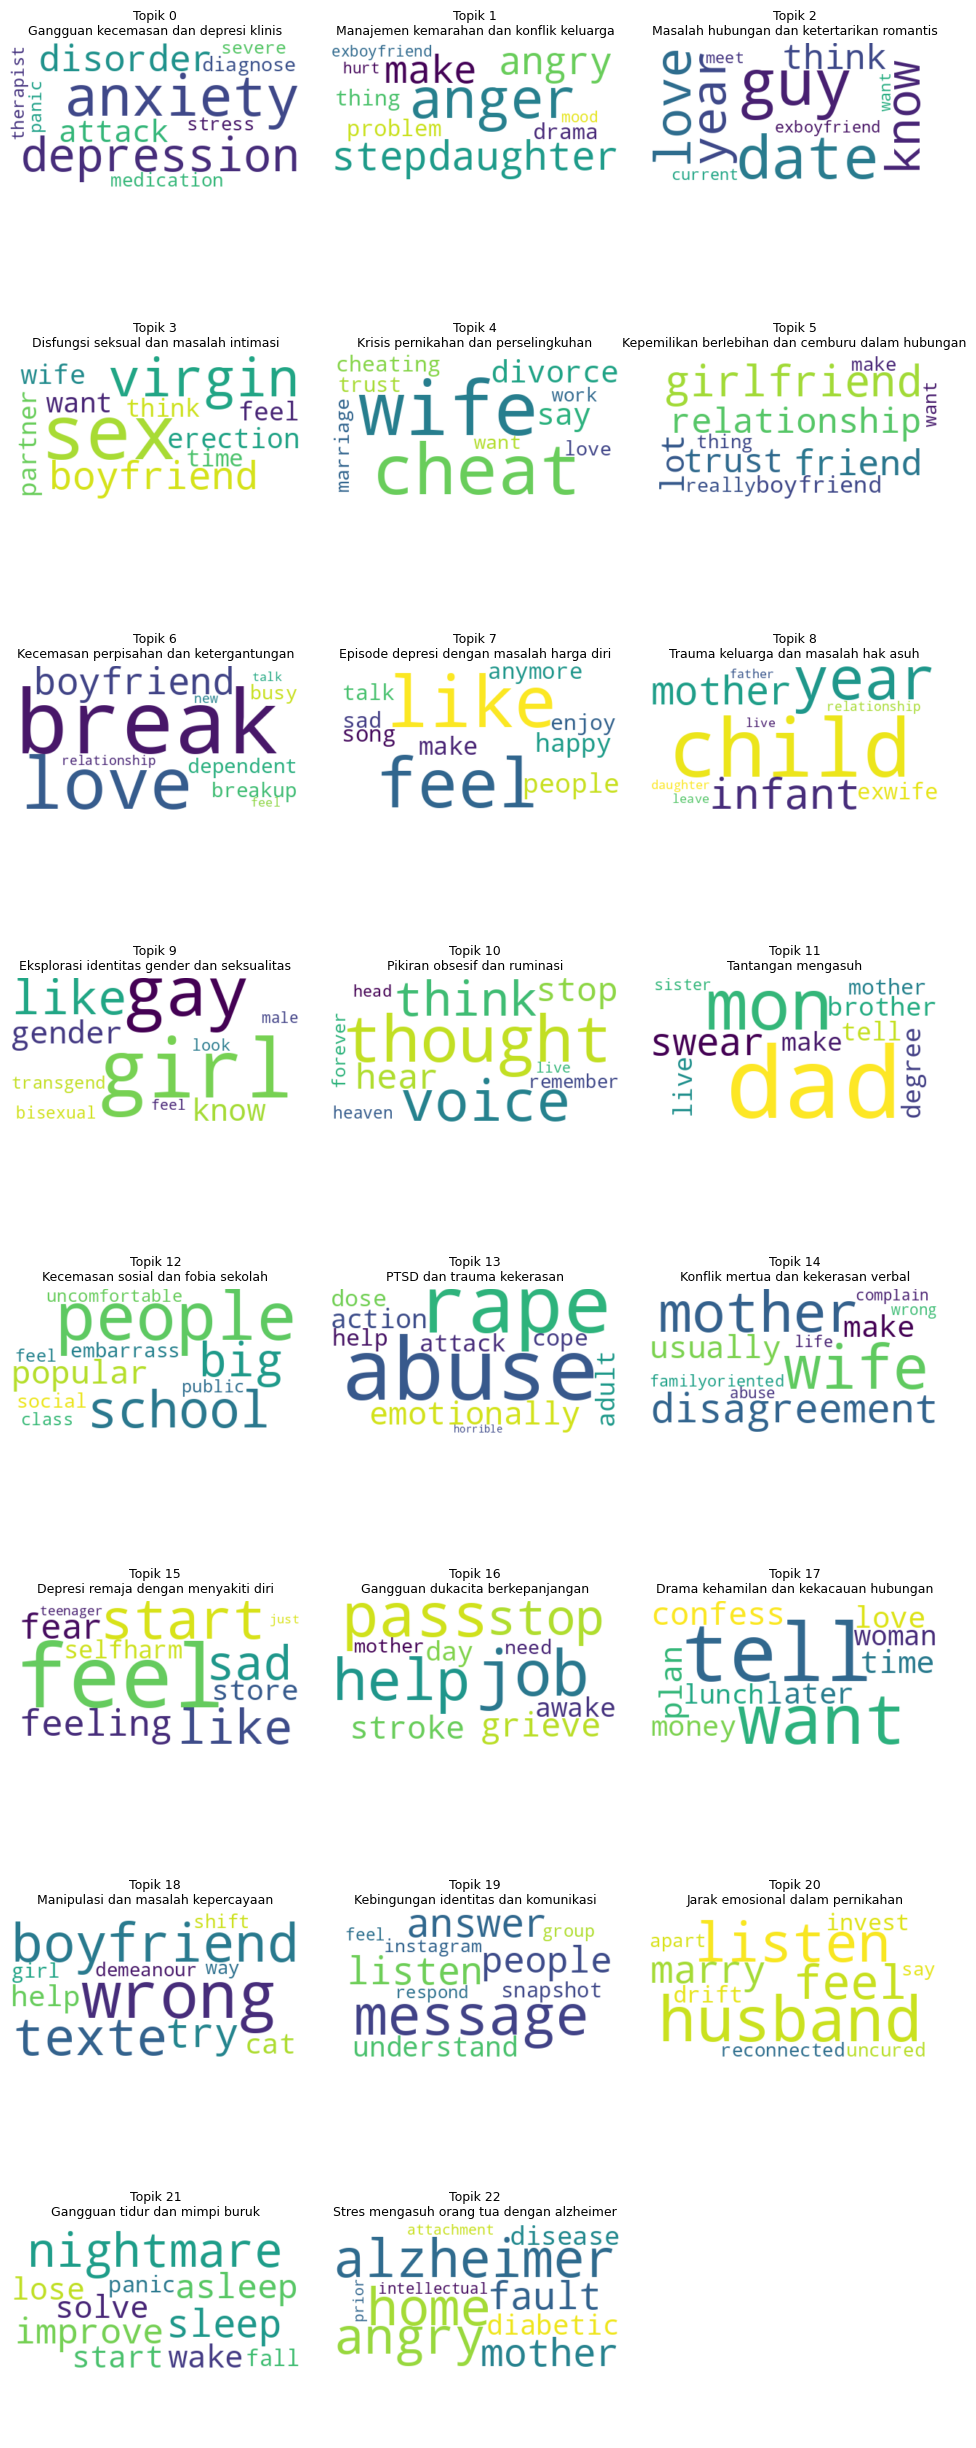

In [ ]:
from bertopic import BERTopic
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

# Load the previously trained BERTopic model
# topic_model = BERTopic.load("/content/drive/MyDrive/Thesis/L-ON_S-ON/bertopic_model")

# Topic labels in Indonesian (English explanation as comment aka ...)
topic_labels = {
    0: "Gangguan kecemasan dan depresi klinis",         # aka Clinical anxiety and depression disorders
    7: "Episode depresi dengan masalah harga diri",     # aka Depressive episode with self-esteem issues
    10: "Pikiran obsesif dan ruminasi",               # aka Obsessive thoughts and rumination
    12: "Kecemasan sosial dan fobia sekolah",        # aka Social anxiety and school phobia
    13: "PTSD dan trauma kekerasan",                  # aka PTSD and violence trauma
    15: "Depresi remaja dengan menyakiti diri",       # aka Adolescent depression with self-harm
    16: "Gangguan dukacita berkepanjangan",           # aka Prolonged grief disorder
    21: "Gangguan tidur dan mimpi buruk",             # aka Sleep disorder and nightmares
    2: "Masalah hubungan dan ketertarikan romantis", # aka Relationship and romantic attraction issues
    3: "Disfungsi seksual dan masalah intimasi",     # aka Sexual dysfunction and intimacy problems
    4: "Krisis pernikahan dan perselingkuhan",       # aka Marital crisis and infidelity
    5: "Kepemilikan berlebihan dan cemburu dalam hubungan", # aka Over-possessiveness and jealousy in relationships
    6: "Kecemasan perpisahan dan ketergantungan",    # aka Separation anxiety and dependency
    17: "Drama kehamilan dan kekacauan hubungan",     # aka Pregnancy drama and relationship chaos
    18: "Manipulasi dan masalah kepercayaan",        # aka Manipulation and trust issues
    20: "Jarak emosional dalam pernikahan",          # aka Emotional distance in marriage
    1: "Manajemen kemarahan dan konflik keluarga",   # aka Anger management and family conflict
    8: "Trauma keluarga dan masalah hak asuh",      # aka Family trauma and custody issues
    11: "Tantangan mengasuh",                        # aka Parenting challenges
    14: "Konflik mertua dan kekerasan verbal",       # aka In-law conflict and verbal abuse
    22: "Stres mengasuh orang tua dengan alzheimer", # aka Caregiver stress for parents with Alzheimer's
    9: "Eksplorasi identitas gender dan seksualitas",# aka Gender identity and sexuality exploration
    19: "Kebingungan identitas dan komunikasi",     # aka Identity confusion and communication issues
}

def plot_wordclouds_lon_son_3cols(model):
    topics = model.get_topics()
    valid_topics = {k: v for k, v in topics.items() if k in topic_labels}
    num_topics = len(valid_topics)

    ncols = 3
    nrows = math.ceil(num_topics / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 4))
    axes = axes.flatten()

    for i, (topic_id, words) in enumerate(valid_topics.items()):
        word_freq = {word: score for word, score in words}
        wc = WordCloud(background_color='white').generate_from_frequencies(word_freq)
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f"Topik {topic_id}\n{topic_labels[topic_id]}", fontsize=9)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Run the function to plot wordclouds
plot_wordclouds_lon_son_3cols(topic_model)


## Outlier Analysis

This section analyzes the number of documents that were not assigned to any topic (outliers) by the BERTopic model. In HDBSCAN, which is used for clustering in BERTopic, documents that do not clearly belong to any cluster are labeled as `-1`.

**Steps:**

1. Load the topic assignments from the saved BERTopic model.
2. Count the number of documents labeled as outliers (`-1`).
3. Calculate the outlier ratio relative to the total number of documents.
4. Display the number and percentage of outliers.

This helps us understand the proportion of documents that may require further preprocessing or manual review.


In [ ]:
import numpy as np

# Load topic assignments from BERTopic model
topics = np.load("/models/raw/topics.npy")

# Count outliers (documents assigned to topic -1)
outlier_count = np.sum(topics == -1)
total_docs = len(topics)
outlier_ratio = outlier_count / total_docs

# Print results
print(f"Number of outliers: {outlier_count} out of {total_docs} documents")
print(f"Outlier ratio: {outlier_ratio:.2%}")


Jumlah outlier: 440 dari 994 dokumen
Rasio outlier: 44.27%


## Qualitative Evaluation

The qualitative evaluation in this study aims to validate the accuracy of topic modeling results within computational text analysis. The main focus is **semantic coherence** and **document clustering accuracy**, rather than clinical or psychological exploration.

**Approach:**

1. **Keyword Coherence and Document Grouping**
   - Active lemmatization is applied to ensure keywords are semantically coherent.
   - Documents are grouped based on textual similarity.
   - Each topic is assessed to ensure meaningful semantic representation.

2. **Adapted Methodology**
   - Inspired by **Thematic Analysis** (Braun & Clarke, 2006), **Narrative Analysis** for context validation, and **Pattern Recognition** in computational linguistics.
   - Integrated with clinical psychology practice standards using references like ICD-11 and DSM-5.

3. **Evaluation Steps**
   - **Step 1: Thematic Analysis**
     - Review topic keyword lists.
     - Match keywords with original document content.
     - Assess internal semantic coherence.
   - **Step 2: Visual Validation**
     - Use `visualize_documents()` to inspect spatial distribution and clustering consistency.
   - **Step 3: Feasibility Assessment**
     - Determine if results can support early exploratory analysis in psychological counseling.
     - Detect overly general, narrow, or irrelevant topics.

4. **Sampling Strategy**
   - Purposeful sampling of three topics representing varying cluster sizes and semantic quality.
   - 3–4 documents per topic, totaling 20 manually reviewed documents.

5. **Triangulation and Expert Consultation**
   - Discussions with a psychiatrist and lecturer in Clinical Psychology to validate relevance.
   - Ensures credibility and domain-informed interpretation.

6. **Visualizations**
   - **Word Clouds**: Show dominant keywords per topic using c-TF-IDF scores.
   - **Histogram**: Displays document counts per topic to evaluate cluster balance and detect overly broad or narrow topics.
   - Visualizations like dendrograms are included in appendices for completeness but not in the main text.

**Goal:**  
Ensure the topic modeling algorithm produces reliable outputs for exploratory analysis in text-based psychological counseling, combining computational methods and domain-informed manual validation.


# Qualitative Topic Evaluation

This table shows the **topics identified by the BERTopic model**, the number of documents in each topic, and **all the keywords associated with the topic**. The goal is to quickly check whether the keywords are semantically coherent and logically connected.

| No | Topic ID | Document Count | Top Words |
|----|----------|----------------|-----------|
| 1  | 0        | 123            | word1, word2, word3, ... |
| 2  | 1        | 95             | word1, word2, word3, ... |
| 3  | 2        | 87             | word1, word2, word3, ... |
| ...| ...      | ...            | ... |
 
- Topics with ID `-1` are **outlier documents** that did not fit into any topic.  
- The purpose of this evaluation is **qualitative**: to verify that the words in each topic make sense together and reflect meaningful semantic grouping.  
- This step does **not** perform a psychological or clinical diagnosis—it is purely a check of topic coherence from the model’s output.


In [ ]:
import pandas as pd
from IPython.display import display

# Get topic information from the BERTopic model
df_topic_info = topic_model.get_topic_info()  # aka topic summary

# Filter valid topics (exclude outliers, i.e., Topic -1)
df_evaluation = df_topic_info[df_topic_info["Topic"] != -1][["Topic", "Count"]].copy()

# Function to get all keywords for a given topic
def get_all_keywords(topic_id):
    topic_words = topic_model.get_topic(topic_id)
    return ", ".join([word for word, _ in topic_words])

# Add a column with all keywords per topic
df_evaluation["Top Words"] = df_evaluation["Topic"].apply(get_all_keywords)

# Add a sequential number column
df_evaluation.insert(0, "No", range(1, len(df_evaluation) + 1))

# Reset index
df_evaluation.reset_index(drop=True, inplace=True)

# Display all rows
pd.set_option('display.max_rows', None)
display(df_evaluation)

# Check for outliers
if -1 in df_topic_info["Topic"].values:
    outlier_count = df_topic_info.loc[df_topic_info["Topic"] == -1, "Count"].values[0]
    print(f"Number of outlier documents (Topic -1): {outlier_count}")
else:
    print("No documents were categorized as outliers.")


# Qualitative Keyword Check

This step performs a **manual inspection** to see whether the keywords of a topic actually appear in the documents assigned to that topic. The goal is to check **logical coherence** between top keywords and document content.

### Procedure
1. Randomly sample a few documents from the dominant topic.
2. Compare the text content with the topic's keywords.
3. Highlight keywords in the text to easily see if they appear.

### Example Output

**📌 Topic 8 — [ keyword1, keyword2, keyword3, ... ]**  
**Number of sampled documents:** 10

**Document 1:**  
This text contains <u>keyword1</u> and <u>keyword3</u>...

**Document 2:**  
Another text mentioning <u>keyword2</u>...

**Important:**  
- Only a small random sample is checked.  
- The focus is on **matching keywords to document content**, not full semantic analysis or clinical interpretation.


In [ ]:
import re
import pandas as pd
from IPython.display import display, HTML

# Load data
combined_q = pd.read_csv("/content/drive/MyDrive/Thesis/combined_questionText.csv")["questionText"]

# Pilih topik
target_topic = 19

# Ambil keyword dari topik
top_words = [w for w, _ in topic_model.get_topic(target_topic)]

# Ambil semua dokumen yang masuk ke topik tersebut
topic_indices = [i for i, t in enumerate(topics) if t == target_topic]

# Fungsi garis bawah keyword & hitung jumlah kemunculannya
def highlight_and_count_keywords(text, keywords):
    count_dict = {}
    for word in keywords:
        pattern = re.compile(rf"{re.escape(word)}", flags=re.IGNORECASE)
        matches = pattern.findall(text)
        count_dict[word] = len(matches)
        text = pattern.sub(f"<u>{word}</u>", text)
    return text, count_dict

# Header tampilan
display(HTML(f"<h3>📌 Topik {target_topic} — Keyword: [ {', '.join(top_words)} ]</h3>"))
display(HTML(f"<b>Total dokumen dalam topik ini:</b> {len(topic_indices)}<br><br>"))

# Tampilkan dokumen
for j, i in enumerate(topic_indices[:10], 1):  # ubah jumlah kalau mau tampilkan lebih banyak
    text = combined_q.iloc[i]
    underlined, counts = highlight_and_count_keywords(text, top_words)
    count_lines = "<br>".join([f"{k}: {v}" for k, v in counts.items() if v > 0])
    display(HTML(f"<b>Dokumen {j} (Index {i}):</b><br>{underlined}<br><br><b>🔍 Jumlah Kemunculan:</b><br>{count_lines}<br><br>"))
